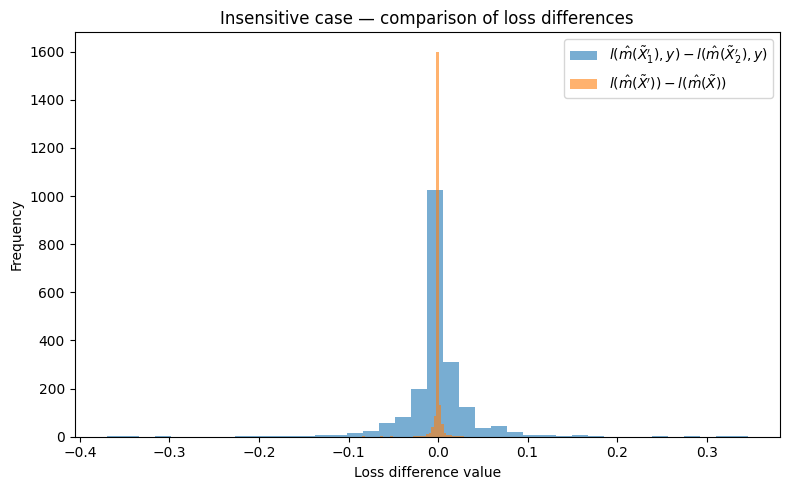

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

def simulate_insensitive(
    n_train=2000, n_aux_nu=2000, n_test=2000, p=5, j=0, rho=0.5, seed=1
):
    np.random.seed(seed)

    # ----- Gaussian design -----
    idx = np.arange(p)
    Sigma = rho ** np.abs(np.subtract.outer(idx, idx))
    mu = np.zeros(p)
    def sample_X(n): return np.random.multivariate_normal(mu, Sigma, size=n)

    X_train, X_aux_nu, X_test = (
        sample_X(n_train), sample_X(n_aux_nu), sample_X(n_test)
    )

    # ----- True conditional mean -----
    idx_minus = [k for k in range(p) if k != j]
    Sigma_jm = Sigma[j, idx_minus]
    Sigma_mm = Sigma[np.ix_(idx_minus, idx_minus)]
    Sigma_mm_inv = np.linalg.inv(Sigma_mm)

    def true_nu(x_minus):
        return (Sigma_jm @ Sigma_mm_inv @ x_minus.T).T

    nu_true_test = true_nu(X_test[:, idx_minus])

    # ----- Estimated conditional mean -----
    reg = LinearRegression().fit(X_aux_nu[:, idx_minus], X_aux_nu[:, j])
    nu_hat_test = reg.predict(X_test[:, idx_minus])

    # ----- Residuals (for both true and estimated means) -----
    res_hat = X_test[:, j] - nu_hat_test
    res_true = X_test[:, j] - nu_true_test

    # same permutation for both
    perm = np.random.permutation(len(X_aux_nu))
    res_hat_perm = res_hat[perm][:n_test]
    res_true_perm = res_true[perm][:n_test]

    # Another permutation for A (second version)
    perm2 = np.random.permutation(len(X_aux_nu))
    res_hat_perm2 = res_hat[perm2][:n_test]

    # ----- Construct variants -----
    X_tilde_p1 = X_test.copy()   # \tilde X'_1
    X_tilde_p1[:, j] = nu_hat_test + res_hat_perm

    X_tilde_p2 = X_test.copy()   # \tilde X'_2
    X_tilde_p2[:, j] = nu_hat_test + res_hat_perm2

    X_tilde_true1 = X_test.copy()  # \tilde X_1
    X_tilde_true1[:, j] = nu_true_test.flatten() + res_true_perm

    # ----- Data-generating process (insensitive to j) -----
    beta = np.array([1.0, 0.8, 0.6, 0.4, 0.2])[:p]
    beta[j] = 0.0  # remove j dependence
    def f_x(X): return X @ beta + 0.5 * np.sin(X[:, 1])

    Y_train = f_x(X_train) + np.random.normal(0, 0.5, n_train)
    Y_test = f_x(X_test) + np.random.normal(0, 0.5, n_test)

    # ----- Train m_hat -----
    m_hat = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=seed)
    m_hat.fit(X_train, Y_train)

    # ----- Predict & losses -----
    def loss(pred, y): return (pred - y) ** 2
    L_p1 = loss(m_hat.predict(X_tilde_p1), Y_test)
    L_p2 = loss(m_hat.predict(X_tilde_p2), Y_test)
    L_true1 = loss(m_hat.predict(X_tilde_true1), Y_test)

    # Quantities of interest
    A = L_p1 - L_p2
    B = L_p1 - L_true1

    return A, B

# -----------------------------
# Run and plot
# -----------------------------
A, B = simulate_insensitive(seed=42)

plt.figure(figsize=(8,5))
plt.hist(A, bins=40, alpha=0.6, label=r"$l(\hat{m}(\tilde{X}_1'), y) - l(\hat{m}(\tilde{X}_2'), y)$")
plt.hist(B, bins=40, alpha=0.6, label=r"$l(\hat{m}(\tilde{X}')) - l(\hat{m}(\tilde{X}))$")
plt.legend()
plt.title("Insensitive case — comparison of loss differences")
plt.xlabel("Loss difference value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


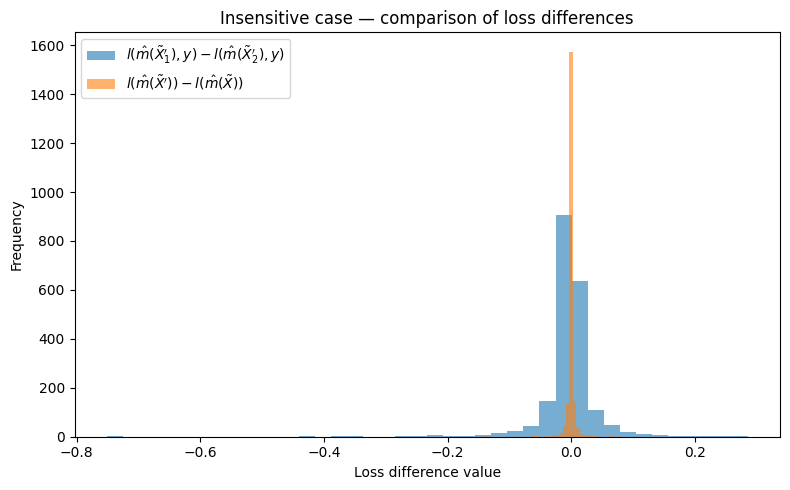

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

def simulate_insensitive(
    n_train=2000, n_test=2000, p=5, j=0, rho=0.5, seed=1
):
    np.random.seed(seed)

    # ----- Gaussian design -----
    idx = np.arange(p)
    Sigma = rho ** np.abs(np.subtract.outer(idx, idx))
    mu = np.zeros(p)
    def sample_X(n): return np.random.multivariate_normal(mu, Sigma, size=n)

    X_train, X_test = (
        sample_X(n_train), sample_X(n_test)
    )

    # ----- True conditional mean -----
    idx_minus = [k for k in range(p) if k != j]
    Sigma_jm = Sigma[j, idx_minus]
    Sigma_mm = Sigma[np.ix_(idx_minus, idx_minus)]
    Sigma_mm_inv = np.linalg.inv(Sigma_mm)

    def true_nu(x_minus):
        return (Sigma_jm @ Sigma_mm_inv @ x_minus.T).T

    nu_true_test = true_nu(X_test[:, idx_minus])

    # ----- Estimated conditional mean -----
    reg = LinearRegression().fit(X_train[:, idx_minus], X_train[:, j])
    nu_hat_test = reg.predict(X_test[:, idx_minus])

    # ----- Residuals (for both true and estimated means) -----
    res_hat = X_test[:, j] - nu_hat_test
    res_true = X_test[:, j] - nu_true_test

    # same permutation for both
    perm = np.random.permutation(len(X_test))
    res_hat_perm = res_hat[perm][:n_test]
    res_true_perm = res_true[perm][:n_test]

    # Another permutation for A (second version)
    perm2 = np.random.permutation(len(X_test))
    res_hat_perm2 = res_hat[perm2][:n_test]

    # ----- Construct variants -----
    X_tilde_p1 = X_test.copy()   # \tilde X'_1
    X_tilde_p1[:, j] = nu_hat_test + res_hat_perm

    X_tilde_p2 = X_test.copy()   # \tilde X'_2
    X_tilde_p2[:, j] = nu_hat_test + res_hat_perm2

    X_tilde_true1 = X_test.copy()  # \tilde X_1
    X_tilde_true1[:, j] = nu_true_test.flatten() + res_true_perm

    # ----- Data-generating process (insensitive to j) -----
    beta = np.array([1.0, 0.8, 0.6, 0.4, 0.2])[:p]
    beta[j] = 0.0  # remove j dependence
    def f_x(X): return X @ beta + 0.5 * np.sin(X[:, 1])

    Y_train = f_x(X_train) + np.random.normal(0, 0.5, n_train)
    Y_test = f_x(X_test) + np.random.normal(0, 0.5, n_test)

    # ----- Train m_hat -----
    m_hat = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=seed)
    m_hat.fit(X_train, Y_train)

    # ----- Predict & losses -----
    def loss(pred, y): return (pred - y) ** 2
    L_p1 = loss(m_hat.predict(X_tilde_p1), Y_test)
    L_p2 = loss(m_hat.predict(X_tilde_p2), Y_test)
    L_true1 = loss(m_hat.predict(X_tilde_true1), Y_test)

    # Quantities of interest
    A = L_p1 - L_p2
    B = L_p1 - L_true1

    return A, B

# -----------------------------
# Run and plot
# -----------------------------
A, B = simulate_insensitive(seed=42)

plt.figure(figsize=(8,5))
plt.hist(A, bins=40, alpha=0.6, label=r"$l(\hat{m}(\tilde{X}_1'), y) - l(\hat{m}(\tilde{X}_2'), y)$")
plt.hist(B, bins=40, alpha=0.6, label=r"$l(\hat{m}(\tilde{X}')) - l(\hat{m}(\tilde{X}))$")
plt.legend()
plt.title("Insensitive case — comparison of loss differences")
plt.xlabel("Loss difference value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


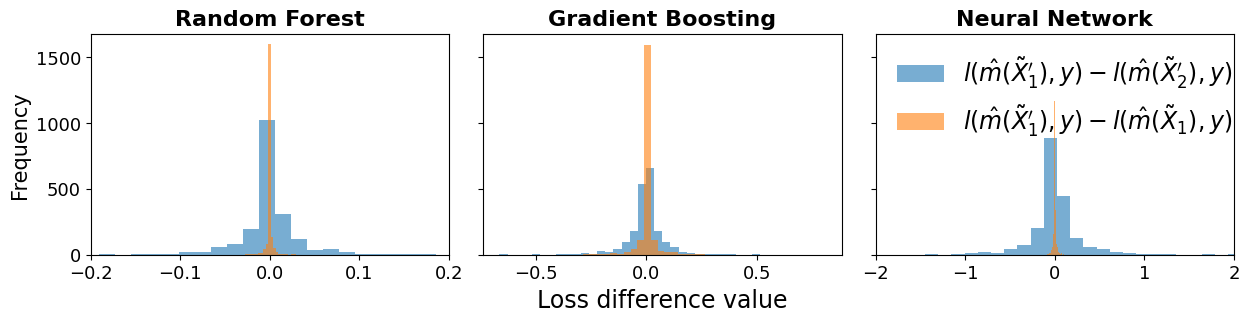

In [18]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

def simulate_insensitive(model_type='RF', seed=1):
    np.random.seed(seed)
    n_train, n_aux_nu, n_test, p, j, rho = 2000, 2000, 2000, 5, 0, 0.5

    # ----- Gaussian design -----
    idx = np.arange(p)
    Sigma = rho ** np.abs(np.subtract.outer(idx, idx))
    mu = np.zeros(p)
    def sample_X(n): return np.random.multivariate_normal(mu, Sigma, size=n)

    X_train, X_aux_nu, X_test = (
        sample_X(n_train), sample_X(n_aux_nu), sample_X(n_test)
    )

    # ----- True conditional mean -----
    idx_minus = [k for k in range(p) if k != j]
    Sigma_jm = Sigma[j, idx_minus]
    Sigma_mm = Sigma[np.ix_(idx_minus, idx_minus)]
    Sigma_mm_inv = np.linalg.inv(Sigma_mm)
    def true_nu(x_minus): return (Sigma_jm @ Sigma_mm_inv @ x_minus.T).T
    nu_true_test = true_nu(X_test[:, idx_minus])

    # ----- Estimated conditional mean -----
    reg = LinearRegression().fit(X_aux_nu[:, idx_minus], X_aux_nu[:, j])
    nu_hat_test = reg.predict(X_test[:, idx_minus])

    # ----- Residuals -----
    res_hat = X_test[:, j] - nu_hat_test
    res_true = X_test[:, j] - nu_true_test
    perm = np.random.permutation(len(X_aux_nu))
    res_hat_perm = res_hat[perm][:n_test]
    res_true_perm = res_true[perm][:n_test]
    perm2 = np.random.permutation(len(X_aux_nu))
    res_hat_perm2 = res_hat[perm2][:n_test]

    # ----- Construct variants -----
    X_tilde_p1 = X_test.copy(); X_tilde_p1[:, j] = nu_hat_test + res_hat_perm
    X_tilde_p2 = X_test.copy(); X_tilde_p2[:, j] = nu_hat_test + res_hat_perm2
    X_tilde_true1 = X_test.copy(); X_tilde_true1[:, j] = nu_true_test.flatten() + res_true_perm

    # ----- Data-generating process (insensitive to j) -----
    beta = np.array([1.0, 0.8, 0.6, 0.4, 0.2])[:p]; beta[j] = 0.0
    def f_x(X): return X @ beta + 0.5 * np.sin(X[:, 1])
    Y_train = f_x(X_train) + np.random.normal(0, 0.5, n_train)
    Y_test = f_x(X_test) + np.random.normal(0, 0.5, n_test)

    # ----- Train m_hat -----
    if model_type == 'RF':
        m_hat = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=seed)
    elif model_type == 'GB':
        m_hat = GradientBoostingRegressor(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=seed)
    elif model_type == 'NN':
        m_hat = MLPRegressor(hidden_layer_sizes=(100,50), activation='relu', solver='adam', max_iter=1000, random_state=seed)
    else:
        raise ValueError("model_type must be 'RF', 'GB', or 'NN'")
    m_hat.fit(X_train, Y_train)

    # ----- Predict & losses -----
    def loss(pred, y): return (pred - y) ** 2
    L_p1 = loss(m_hat.predict(X_tilde_p1), Y_test)
    L_p2 = loss(m_hat.predict(X_tilde_p2), Y_test)
    L_true1 = loss(m_hat.predict(X_tilde_true1), Y_test)

    A = L_p1 - L_p2
    B = L_p1 - L_true1
    return A, B

# -----------------------------
# Run and plot consecutively
# -----------------------------
models = ['RF', 'GB', 'NN']
titles = ['Random Forest', 'Gradient Boosting', 'Neural Network']

fig, axes = plt.subplots(1, len(models), figsize=(12.6, 3.5), sharey=True)

for ax, model, title in zip(axes, models, titles):
    A, B = simulate_insensitive(model_type=model, seed=42)
    
    # Plot histograms
    ax.hist(A, bins=40, alpha=0.6, label=r"$l(\hat{m}(\tilde{X}_1'), y) - l(\hat{m}(\tilde{X}_2'), y)$")
    ax.hist(B, bins=40, alpha=0.6, label=r"$l(\hat{m}(\tilde{X}_1'), y) - l(\hat{m}(\tilde{X}_1), y)$")
    
    # Titles & labels
    ax.set_title(title, fontsize=16, fontweight='bold')
    #ax.set_xlabel("Loss difference value", fontsize=13)
    ax.tick_params(axis='both', labelsize=13)

fig.subplots_adjust(wspace=-0.25)   # smaller = less space
# Shared Y label
axes[0].set_ylabel("Frequency", fontsize=15)
axes[1].set_xlabel("Loss difference value", fontsize=17)

# Legend inside the first plot (top-left corner)
axes[2].legend(fontsize=17, loc='upper left', frameon=False)
axes[0].set_xlim(-0.2, 0.2)
axes[2].set_xlim(-2, 2)
# Global title
#fig.suptitle(r"Double Robustness", fontsize=28, fontweight='bold', y=1.0)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"figures/DR_main.pdf", bbox_inches="tight")
plt.show()


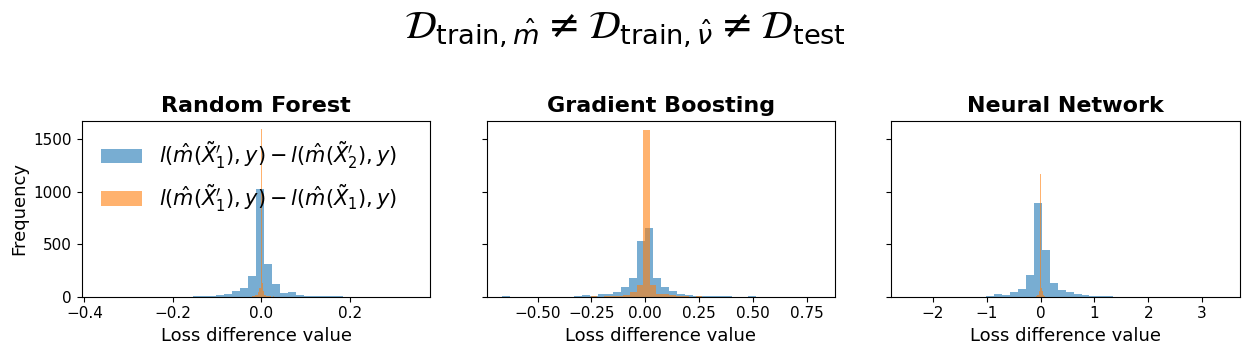

In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

def simulate_insensitive(model_type='RF', seed=1):
    np.random.seed(seed)
    n_train, n_aux_nu, n_test, p, j, rho = 2000, 2000, 2000, 5, 0, 0.5

    # ----- Gaussian design -----
    idx = np.arange(p)
    Sigma = rho ** np.abs(np.subtract.outer(idx, idx))
    mu = np.zeros(p)
    def sample_X(n): return np.random.multivariate_normal(mu, Sigma, size=n)

    X_train, X_aux_nu, X_test = (
        sample_X(n_train), sample_X(n_aux_nu), sample_X(n_test)
    )

    # ----- True conditional mean -----
    idx_minus = [k for k in range(p) if k != j]
    Sigma_jm = Sigma[j, idx_minus]
    Sigma_mm = Sigma[np.ix_(idx_minus, idx_minus)]
    Sigma_mm_inv = np.linalg.inv(Sigma_mm)
    def true_nu(x_minus): return (Sigma_jm @ Sigma_mm_inv @ x_minus.T).T
    nu_true_test = true_nu(X_test[:, idx_minus])

    # ----- Estimated conditional mean -----
    reg = LinearRegression().fit(X_aux_nu[:, idx_minus], X_aux_nu[:, j])
    nu_hat_test = reg.predict(X_test[:, idx_minus])

    # ----- Residuals -----
    res_hat = X_test[:, j] - nu_hat_test
    res_true = X_test[:, j] - nu_true_test
    perm = np.random.permutation(len(X_aux_nu))
    res_hat_perm = res_hat[perm][:n_test]
    res_true_perm = res_true[perm][:n_test]
    perm2 = np.random.permutation(len(X_aux_nu))
    res_hat_perm2 = res_hat[perm2][:n_test]

    # ----- Construct variants -----
    X_tilde_p1 = X_test.copy(); X_tilde_p1[:, j] = nu_hat_test + res_hat_perm
    X_tilde_p2 = X_test.copy(); X_tilde_p2[:, j] = nu_hat_test + res_hat_perm2
    X_tilde_true1 = X_test.copy(); X_tilde_true1[:, j] = nu_true_test.flatten() + res_true_perm

    # ----- Data-generating process (insensitive to j) -----
    beta = np.array([1.0, 0.8, 0.6, 0.4, 0.2])[:p]; beta[j] = 0.0
    def f_x(X): return X @ beta + 0.5 * np.sin(X[:, 1])
    Y_train = f_x(X_train) + np.random.normal(0, 0.5, n_train)
    Y_test = f_x(X_test) + np.random.normal(0, 0.5, n_test)

    # ----- Train m_hat -----
    if model_type == 'RF':
        m_hat = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=seed)
    elif model_type == 'GB':
        m_hat = GradientBoostingRegressor(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=seed)
    elif model_type == 'NN':
        m_hat = MLPRegressor(hidden_layer_sizes=(100,50), activation='relu', solver='adam', max_iter=1000, random_state=seed)
    else:
        raise ValueError("model_type must be 'RF', 'GB', or 'NN'")
    m_hat.fit(X_train, Y_train)

    # ----- Predict & losses -----
    def loss(pred, y): return (pred - y) ** 2
    L_p1 = loss(m_hat.predict(X_tilde_p1), Y_test)
    L_p2 = loss(m_hat.predict(X_tilde_p2), Y_test)
    L_true1 = loss(m_hat.predict(X_tilde_true1), Y_test)

    A = L_p1 - L_p2
    B = L_p1 - L_true1
    return A, B

# -----------------------------
# Run and plot consecutively
# -----------------------------
models = ['RF', 'GB', 'NN']
titles = ['Random Forest', 'Gradient Boosting', 'Neural Network']

fig, axes = plt.subplots(1, len(models), figsize=(12.6, 3.5), sharey=True)

for ax, model, title in zip(axes, models, titles):
    A, B = simulate_insensitive(model_type=model, seed=42)
    
    # Plot histograms
    ax.hist(A, bins=40, alpha=0.6, label=r"$l(\hat{m}(\tilde{X}_1'), y) - l(\hat{m}(\tilde{X}_2'), y)$")
    ax.hist(B, bins=40, alpha=0.6, label=r"$l(\hat{m}(\tilde{X}_1'), y) - l(\hat{m}(\tilde{X}_1), y)$")
    
    # Titles & labels
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel("Loss difference value", fontsize=13)
    ax.tick_params(axis='both', labelsize=11)

# Shared Y label
axes[0].set_ylabel("Frequency", fontsize=13)

# Legend inside the first plot (top-left corner)
axes[0].legend(fontsize=15, loc='upper left', frameon=False)

# Global title
fig.suptitle(r"$\mathcal{D}_{\mathrm{train}, \hat{m}}\neq\mathcal{D}_{\mathrm{train}, \hat{\nu}}\neq\mathcal{D}_\mathrm{test}$", fontsize=28, fontweight='bold', y=1.0)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"figures/DR_sep_D.pdf", bbox_inches="tight")
plt.show()


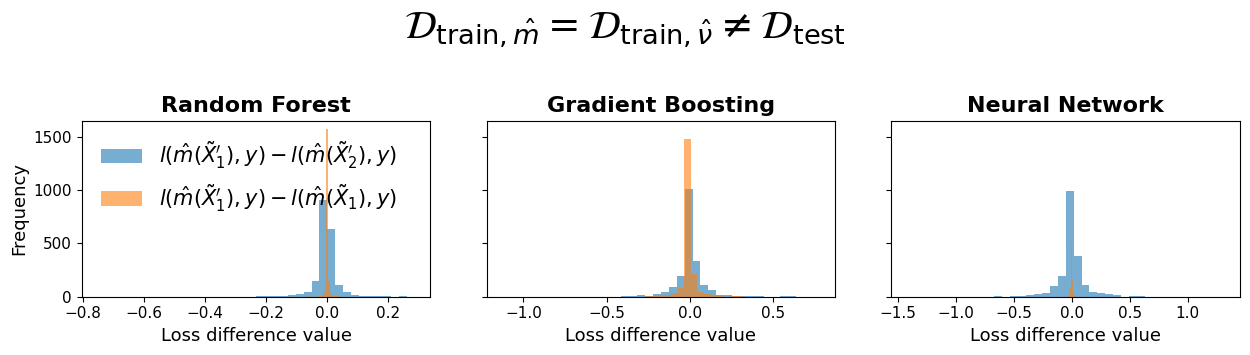

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

def simulate_insensitive(model_type='RF', seed=1):
    np.random.seed(seed)
    n_train, n_test, p, j, rho = 2000, 2000, 5, 0, 0.5

    # ----- Gaussian design -----
    idx = np.arange(p)
    Sigma = rho ** np.abs(np.subtract.outer(idx, idx))
    mu = np.zeros(p)
    def sample_X(n): return np.random.multivariate_normal(mu, Sigma, size=n)

    X_train, X_test = (
        sample_X(n_train), sample_X(n_test)
    )

    # ----- True conditional mean -----
    idx_minus = [k for k in range(p) if k != j]
    Sigma_jm = Sigma[j, idx_minus]
    Sigma_mm = Sigma[np.ix_(idx_minus, idx_minus)]
    Sigma_mm_inv = np.linalg.inv(Sigma_mm)
    def true_nu(x_minus): return (Sigma_jm @ Sigma_mm_inv @ x_minus.T).T
    nu_true_test = true_nu(X_test[:, idx_minus])

    # ----- Estimated conditional mean -----
    reg = LinearRegression().fit(X_train[:, idx_minus], X_train[:, j])
    nu_hat_test = reg.predict(X_test[:, idx_minus])

    # ----- Residuals -----
    res_hat = X_test[:, j] - nu_hat_test
    res_true = X_test[:, j] - nu_true_test
    perm = np.random.permutation(len(X_test))
    res_hat_perm = res_hat[perm][:n_test]
    res_true_perm = res_true[perm][:n_test]
    perm2 = np.random.permutation(len(X_test))
    res_hat_perm2 = res_hat[perm2][:n_test]

    # ----- Construct variants -----
    X_tilde_p1 = X_test.copy(); X_tilde_p1[:, j] = nu_hat_test + res_hat_perm
    X_tilde_p2 = X_test.copy(); X_tilde_p2[:, j] = nu_hat_test + res_hat_perm2
    X_tilde_true1 = X_test.copy(); X_tilde_true1[:, j] = nu_true_test.flatten() + res_true_perm

    # ----- Data-generating process (insensitive to j) -----
    beta = np.array([1.0, 0.8, 0.6, 0.4, 0.2])[:p]; beta[j] = 0.0
    def f_x(X): return X @ beta + 0.5 * np.sin(X[:, 1])
    Y_train = f_x(X_train) + np.random.normal(0, 0.5, n_train)
    Y_test = f_x(X_test) + np.random.normal(0, 0.5, n_test)

    # ----- Train m_hat -----
    if model_type == 'RF':
        m_hat = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=seed)
    elif model_type == 'GB':
        m_hat = GradientBoostingRegressor(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=seed)
    elif model_type == 'NN':
        m_hat = MLPRegressor(hidden_layer_sizes=(100,50), activation='relu', solver='adam', max_iter=1000, random_state=seed)
    else:
        raise ValueError("model_type must be 'RF', 'GB', or 'NN'")
    m_hat.fit(X_train, Y_train)

    # ----- Predict & losses -----
    def loss(pred, y): return (pred - y) ** 2
    L_p1 = loss(m_hat.predict(X_tilde_p1), Y_test)
    L_p2 = loss(m_hat.predict(X_tilde_p2), Y_test)
    L_true1 = loss(m_hat.predict(X_tilde_true1), Y_test)

    A = L_p1 - L_p2
    B = L_p1 - L_true1
    return A, B

# -----------------------------
# Run and plot consecutively
# -----------------------------
models = ['RF', 'GB', 'NN']
titles = ['Random Forest', 'Gradient Boosting', 'Neural Network']

fig, axes = plt.subplots(1, len(models), figsize=(12.6, 3.5), sharey=True)

for ax, model, title in zip(axes, models, titles):
    A, B = simulate_insensitive(model_type=model, seed=42)
    
    # Plot histograms
    ax.hist(A, bins=40, alpha=0.6, label=r"$l(\hat{m}(\tilde{X}_1'), y) - l(\hat{m}(\tilde{X}_2'), y)$")
    ax.hist(B, bins=40, alpha=0.6, label=r"$l(\hat{m}(\tilde{X}_1'), y) - l(\hat{m}(\tilde{X}_1), y)$")
    
    # Titles & labels
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel("Loss difference value", fontsize=13)
    ax.tick_params(axis='both', labelsize=11)

# Shared Y label
axes[0].set_ylabel("Frequency", fontsize=13)

# Legend inside the first plot (top-left corner)
axes[0].legend(fontsize=15, loc='upper left', frameon=False)

# Global title
fig.suptitle(r"$\mathcal{D}_{\mathrm{train}, \hat{m}}=\mathcal{D}_{\mathrm{train}, \hat{\nu}}\neq\mathcal{D}_\mathrm{test}$", fontsize=28, fontweight='bold', y=1.0)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"figures/DR_med_D.pdf", bbox_inches="tight")
plt.show()


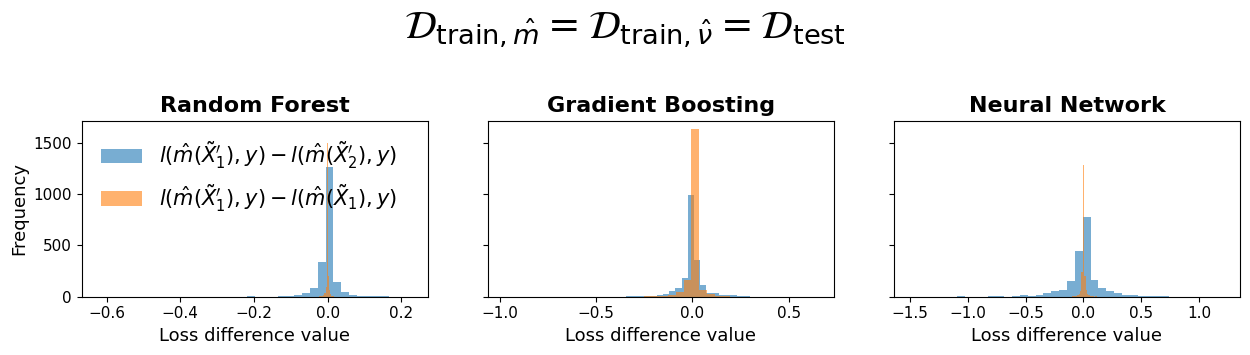

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

def simulate_insensitive(model_type='RF', seed=1):
    np.random.seed(seed)
    n, p, j, rho = 2000, 5, 0, 0.5

    # ----- Gaussian design -----
    idx = np.arange(p)
    Sigma = rho ** np.abs(np.subtract.outer(idx, idx))
    mu = np.zeros(p)
    def sample_X(n): return np.random.multivariate_normal(mu, Sigma, size=n)

    X = (
        sample_X(n)
    )

    # ----- True conditional mean -----
    idx_minus = [k for k in range(p) if k != j]
    Sigma_jm = Sigma[j, idx_minus]
    Sigma_mm = Sigma[np.ix_(idx_minus, idx_minus)]
    Sigma_mm_inv = np.linalg.inv(Sigma_mm)
    def true_nu(x_minus): return (Sigma_jm @ Sigma_mm_inv @ x_minus.T).T
    nu_true_test = true_nu(X[:, idx_minus])

    # ----- Estimated conditional mean -----
    reg = LinearRegression().fit(X[:, idx_minus], X[:, j])
    nu_hat_test = reg.predict(X[:, idx_minus])

    # ----- Residuals -----
    res_hat = X[:, j] - nu_hat_test
    res_true = X[:, j] - nu_true_test
    perm = np.random.permutation(len(X))
    res_hat_perm = res_hat[perm][:n]
    res_true_perm = res_true[perm][:n]
    perm2 = np.random.permutation(len(X))
    res_hat_perm2 = res_hat[perm2][:n]

    # ----- Construct variants -----
    X_tilde_p1 = X.copy(); X_tilde_p1[:, j] = nu_hat_test + res_hat_perm
    X_tilde_p2 = X.copy(); X_tilde_p2[:, j] = nu_hat_test + res_hat_perm2
    X_tilde_true1 = X.copy(); X_tilde_true1[:, j] = nu_true_test.flatten() + res_true_perm

    # ----- Data-generating process (insensitive to j) -----
    beta = np.array([1.0, 0.8, 0.6, 0.4, 0.2])[:p]; beta[j] = 0.0
    def f_x(X): return X @ beta + 0.5 * np.sin(X[:, 1])
    Y = f_x(X) + np.random.normal(0, 0.5, n)

    # ----- Train m_hat -----
    if model_type == 'RF':
        m_hat = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=seed)
    elif model_type == 'GB':
        m_hat = GradientBoostingRegressor(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=seed)
    elif model_type == 'NN':
        m_hat = MLPRegressor(hidden_layer_sizes=(100,50), activation='relu', solver='adam', max_iter=1000, random_state=seed)
    else:
        raise ValueError("model_type must be 'RF', 'GB', or 'NN'")
    m_hat.fit(X, Y)

    # ----- Predict & losses -----
    def loss(pred, y): return (pred - y) ** 2
    L_p1 = loss(m_hat.predict(X_tilde_p1), Y)
    L_p2 = loss(m_hat.predict(X_tilde_p2), Y)
    L_true1 = loss(m_hat.predict(X_tilde_true1), Y)

    A = L_p1 - L_p2
    B = L_p1 - L_true1
    return A, B

# -----------------------------
# Run and plot consecutively
# -----------------------------
models = ['RF', 'GB', 'NN']
titles = ['Random Forest', 'Gradient Boosting', 'Neural Network']


fig, axes = plt.subplots(1, len(models), figsize=(12.6, 3.5), sharey=True)

for ax, model, title in zip(axes, models, titles):
    A, B = simulate_insensitive(model_type=model, seed=42)
    
    # Plot histograms
    ax.hist(A, bins=40, alpha=0.6, label=r"$l(\hat{m}(\tilde{X}_1'), y) - l(\hat{m}(\tilde{X}_2'), y)$")
    ax.hist(B, bins=40, alpha=0.6, label=r"$l(\hat{m}(\tilde{X}_1'), y) - l(\hat{m}(\tilde{X}_1), y)$")
    
    # Titles & labels
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel("Loss difference value", fontsize=13)
    ax.tick_params(axis='both', labelsize=11)

# Shared Y label
axes[0].set_ylabel("Frequency", fontsize=13)

# Legend inside the first plot (top-left corner)
axes[0].legend(fontsize=15, loc='upper left', frameon=False)

# Global title
fig.suptitle(r"$\mathcal{D}_{\mathrm{train}, \hat{m}}=\mathcal{D}_{\mathrm{train}, \hat{\nu}}=\mathcal{D}_\mathrm{test}$", fontsize=28, fontweight='bold', y=1.0)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"figures/DR_unique_D.pdf", bbox_inches="tight")
plt.show()


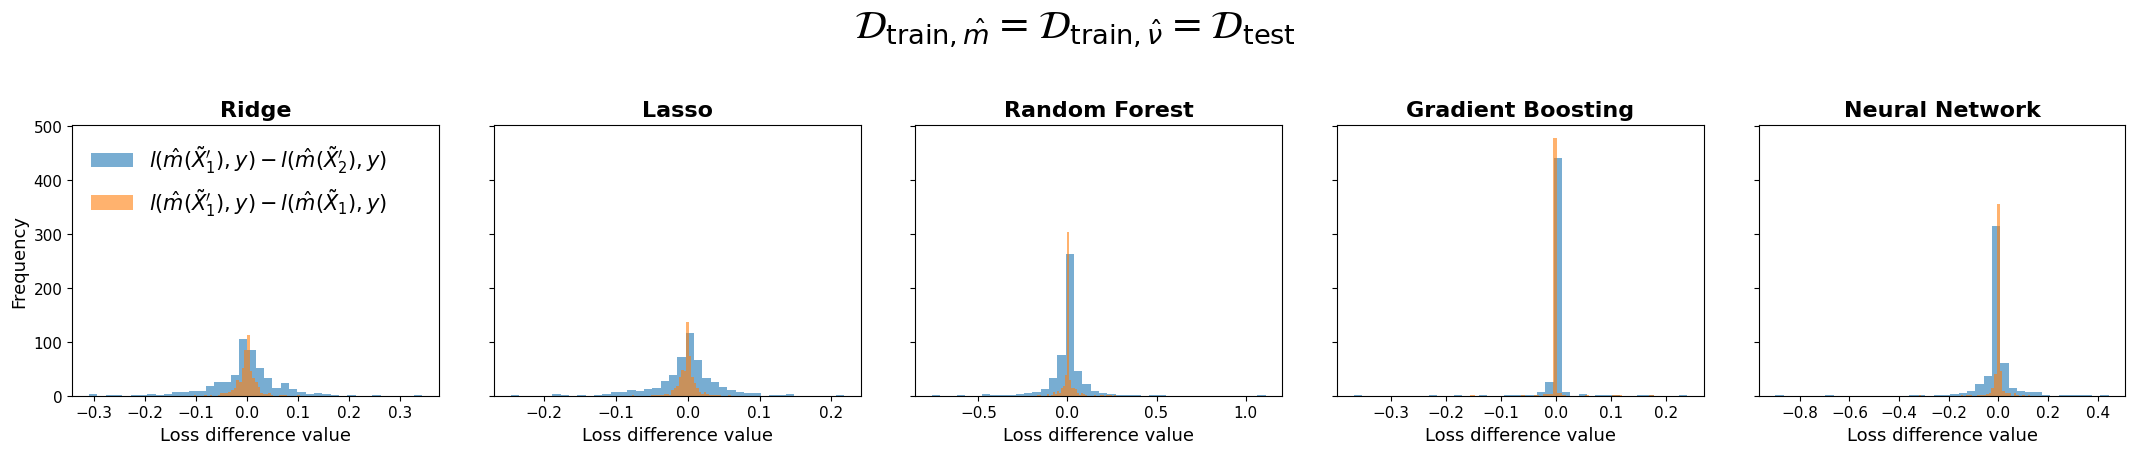

In [7]:
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

def simulate_insensitive(model_type='RF', seed=1):
    np.random.seed(seed)
    n, p, j, rho = 500, 50, 0, 0.5  # high-dimensional setup

    # ----- Gaussian design -----
    idx = np.arange(p)
    Sigma = rho ** np.abs(np.subtract.outer(idx, idx))
    mu = np.zeros(p)
    def sample_X(n): return np.random.multivariate_normal(mu, Sigma, size=n)

    X = sample_X(n)

    # ----- True conditional mean -----
    idx_minus = [k for k in range(p) if k != j]
    Sigma_jm = Sigma[j, idx_minus]
    Sigma_mm = Sigma[np.ix_(idx_minus, idx_minus)]
    Sigma_mm_inv = np.linalg.inv(Sigma_mm)
    def true_nu(x_minus): return (Sigma_jm @ Sigma_mm_inv @ x_minus.T).T
    nu_true_test = true_nu(X[:, idx_minus])

    # ----- Estimated conditional mean (Ridge regression) -----
    reg = Ridge(alpha=1.0).fit(X[:, idx_minus], X[:, j])
    nu_hat_test = reg.predict(X[:, idx_minus])

    # ----- Residuals -----
    res_hat = X[:, j] - nu_hat_test
    res_true = X[:, j] - nu_true_test
    perm = np.random.permutation(len(X))
    res_hat_perm = res_hat[perm][:n]
    res_true_perm = res_true[perm][:n]
    perm2 = np.random.permutation(len(X))
    res_hat_perm2 = res_hat[perm2][:n]

    # ----- Construct variants -----
    X_tilde_p1 = X.copy(); X_tilde_p1[:, j] = nu_hat_test + res_hat_perm
    X_tilde_p2 = X.copy(); X_tilde_p2[:, j] = nu_hat_test + res_hat_perm2
    X_tilde_true1 = X.copy(); X_tilde_true1[:, j] = nu_true_test.flatten() + res_true_perm

    # ----- Complex linear DGP -----
    sparsity = 0.5  # fraction of nonzero coefficients (e.g., 0.2 → 20% active)
    num_nonzero = int(sparsity * p)

    beta = np.zeros(p)
    nonzero_idx = np.random.choice(np.delete(np.arange(p), j), size=num_nonzero, replace=False)

    # Split positives and negatives
    half = num_nonzero // 2
    beta[nonzero_idx[:half]] = np.linspace(1.0, 0.3, half)
    beta[nonzero_idx[half:]] = -np.linspace(0.8, 0.2, num_nonzero - half)
    beta[j] = 0.0

    def f_x(X): return X @ beta
    Y = f_x(X) + np.random.normal(0, 0.5, n)

    # ----- Train m_hat -----
    if model_type == 'RF':
        m_hat = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=seed)
    elif model_type == 'GB':
        m_hat = GradientBoostingRegressor(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=seed)
    elif model_type == 'NN':
        m_hat = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000, random_state=seed)
    elif model_type == 'Ridge':
        m_hat = Ridge(alpha=1.0)
    elif model_type == 'Lasso':
        m_hat = Lasso(alpha=0.05, max_iter=5000)
    else:
        raise ValueError("model_type must be 'RF', 'GB', 'NN', 'Ridge', or 'Lasso'")
    
    m_hat.fit(X, Y)

    # ----- Predict & losses -----
    def loss(pred, y): return (pred - y) ** 2
    L_p1 = loss(m_hat.predict(X_tilde_p1), Y)
    L_p2 = loss(m_hat.predict(X_tilde_p2), Y)
    L_true1 = loss(m_hat.predict(X_tilde_true1), Y)

    A = L_p1 - L_p2
    B = L_p1 - L_true1
    return A, B


# -----------------------------
# Run and plot consecutively
# -----------------------------
models = ['Ridge', 'Lasso', 'RF', 'GB', 'NN']
titles = ['Ridge', 'Lasso', 'Random Forest', 'Gradient Boosting', 'Neural Network']

fig, axes = plt.subplots(1, len(models), figsize=(21.6, 4.5), sharey=True)

for ax, model, title in zip(axes, models, titles):
    A, B = simulate_insensitive(model_type=model, seed=42)
    
    # Plot histograms
    ax.hist(A, bins=40, alpha=0.6, label=r"$l(\hat{m}(\tilde{X}_1'), y) - l(\hat{m}(\tilde{X}_2'), y)$")
    ax.hist(B, bins=40, alpha=0.6, label=r"$l(\hat{m}(\tilde{X}_1'), y) - l(\hat{m}(\tilde{X}_1), y)$")
    
    # Titles & labels
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel("Loss difference value", fontsize=13)
    ax.tick_params(axis='both', labelsize=11)

# Shared Y label
axes[0].set_ylabel("Frequency", fontsize=13)

# Legend inside the first plot (top-left corner)
axes[0].legend(fontsize=15, loc='upper left', frameon=False)

# Global title
fig.suptitle(
    r"$\mathcal{D}_{\mathrm{train}, \hat{m}}=\mathcal{D}_{\mathrm{train}, \hat{\nu}}=\mathcal{D}_\mathrm{test}$",
    fontsize=28, fontweight='bold', y=1.0
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("figures/DR_highdim_complex_linear.pdf", bbox_inches="tight")
plt.show()


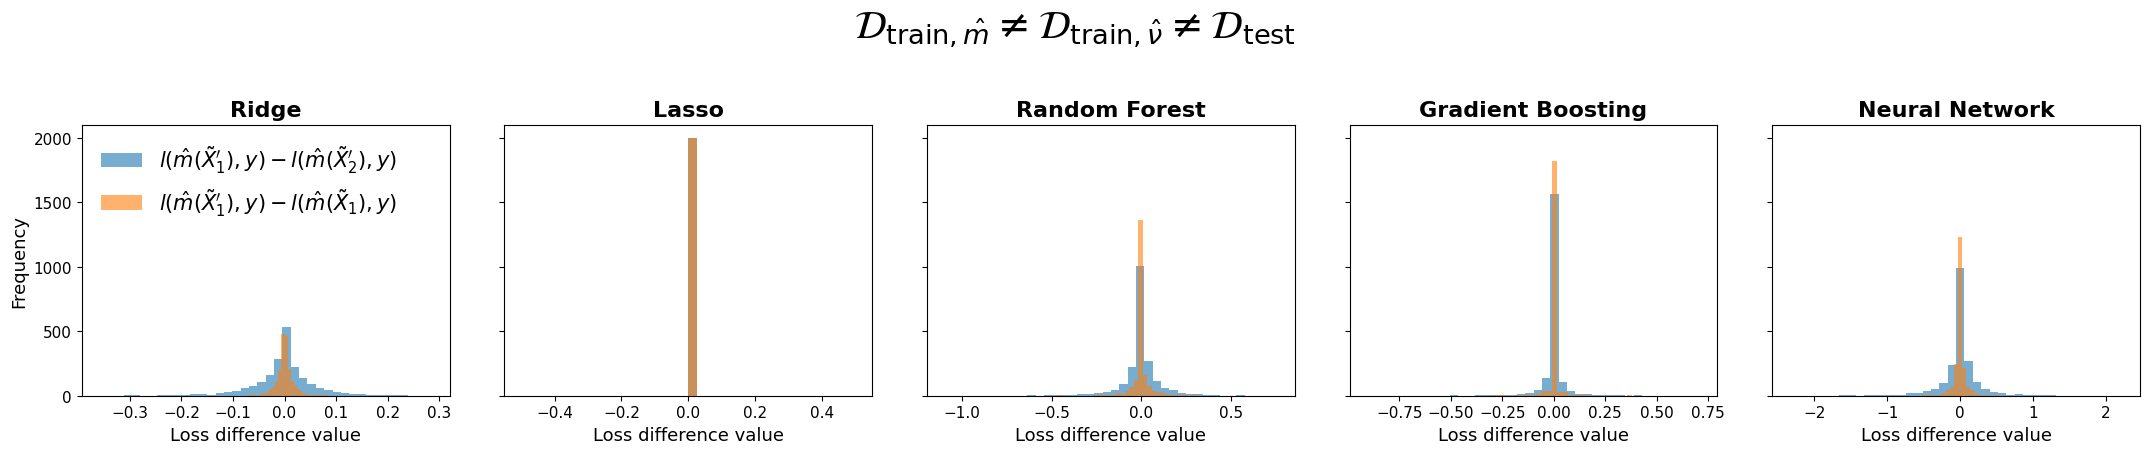

In [8]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

def simulate_insensitive(model_type='RF', seed=1):
    np.random.seed(seed)
    n_train, n_aux_nu, n_test, p, j, rho = 500, 2000, 2000, 50, 0, 0.5

    # ----- Gaussian design -----
    idx = np.arange(p)
    Sigma = rho ** np.abs(np.subtract.outer(idx, idx))
    mu = np.zeros(p)
    def sample_X(n): return np.random.multivariate_normal(mu, Sigma, size=n)

    X_train, X_aux_nu, X_test = (
        sample_X(n_train), sample_X(n_aux_nu), sample_X(n_test)
    )

    # ----- True conditional mean -----
    idx_minus = [k for k in range(p) if k != j]
    Sigma_jm = Sigma[j, idx_minus]
    Sigma_mm = Sigma[np.ix_(idx_minus, idx_minus)]
    Sigma_mm_inv = np.linalg.inv(Sigma_mm)
    def true_nu(x_minus): return (Sigma_jm @ Sigma_mm_inv @ x_minus.T).T
    nu_true_test = true_nu(X_test[:, idx_minus])

    # ----- Estimated conditional mean -----
    reg = Ridge(alpha=1.0).fit(X_train[:, idx_minus], X_train[:, j])
    nu_hat_test = reg.predict(X_test[:, idx_minus])

    # ----- Residuals -----
    res_hat = X_test[:, j] - nu_hat_test
    res_true = X_test[:, j] - nu_true_test
    perm = np.random.permutation(len(X_aux_nu))
    res_hat_perm = res_hat[perm][:n_test]
    res_true_perm = res_true[perm][:n_test]
    perm2 = np.random.permutation(len(X_aux_nu))
    res_hat_perm2 = res_hat[perm2][:n_test]

    # ----- Construct variants -----
    X_tilde_p1 = X_test.copy(); X_tilde_p1[:, j] = nu_hat_test + res_hat_perm
    X_tilde_p2 = X_test.copy(); X_tilde_p2[:, j] = nu_hat_test + res_hat_perm2
    X_tilde_true1 = X_test.copy(); X_tilde_true1[:, j] = nu_true_test.flatten() + res_true_perm

    sparsity = 0.5  # fraction of nonzero coefficients (e.g., 0.2 → 20% active)
    num_nonzero = int(sparsity * p)

    beta = np.zeros(p)
    nonzero_idx = np.random.choice(np.delete(np.arange(p), j), size=num_nonzero, replace=False)

    # Split positives and negatives
    half = num_nonzero // 2
    beta[nonzero_idx[:half]] = np.linspace(1.0, 0.3, half)
    beta[nonzero_idx[half:]] = -np.linspace(0.8, 0.2, num_nonzero - half)
    beta[j] = 0.0

    def f_x(X): return X @ beta
    Y_train = f_x(X_train) + np.random.normal(0, 0.5, n_train)
    Y_test = f_x(X_test) + np.random.normal(0, 0.5, n_test)

    # ----- Train m_hat -----
    if model_type == 'RF':
        m_hat = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=seed)
    elif model_type == 'GB':
        m_hat = GradientBoostingRegressor(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=seed)
    elif model_type == 'NN':
        m_hat = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000, random_state=seed)
    elif model_type == 'Ridge':
        m_hat = Ridge(alpha=1.0)
    elif model_type == 'Lasso':
        m_hat = Lasso(alpha=0.05, max_iter=5000)
    else:
        raise ValueError("model_type must be 'RF', 'GB', 'NN', 'Ridge', or 'Lasso'")
    
    m_hat.fit(X_train, Y_train)

    # ----- Predict & losses -----
    def loss(pred, y): return (pred - y) ** 2
    L_p1 = loss(m_hat.predict(X_tilde_p1), Y_test)
    L_p2 = loss(m_hat.predict(X_tilde_p2), Y_test)
    L_true1 = loss(m_hat.predict(X_tilde_true1), Y_test)

    A = L_p1 - L_p2
    B = L_p1 - L_true1
    return A, B

# -----------------------------
# Run and plot consecutively
# -----------------------------
models = ['Ridge', 'Lasso', 'RF', 'GB', 'NN']
titles = ['Ridge', 'Lasso', 'Random Forest', 'Gradient Boosting', 'Neural Network']

fig, axes = plt.subplots(1, len(models), figsize=(21.6, 4.5), sharey=True)

for ax, model, title in zip(axes, models, titles):
    A, B = simulate_insensitive(model_type=model, seed=42)
    
    # Plot histograms
    ax.hist(A, bins=40, alpha=0.6, label=r"$l(\hat{m}(\tilde{X}_1'), y) - l(\hat{m}(\tilde{X}_2'), y)$")
    ax.hist(B, bins=40, alpha=0.6, label=r"$l(\hat{m}(\tilde{X}_1'), y) - l(\hat{m}(\tilde{X}_1), y)$")
    
    # Titles & labels
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel("Loss difference value", fontsize=13)
    ax.tick_params(axis='both', labelsize=11)

# Shared Y label
axes[0].set_ylabel("Frequency", fontsize=13)

# Legend inside the first plot (top-left corner)
axes[0].legend(fontsize=15, loc='upper left', frameon=False)

# Global title
fig.suptitle(
    r"$\mathcal{D}_{\mathrm{train}, \hat{m}}\neq\mathcal{D}_{\mathrm{train}, \hat{\nu}}\neq\mathcal{D}_\mathrm{test}$",
    fontsize=28, fontweight='bold', y=1.0
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("figures/DR_highdim_sep_linear.pdf", bbox_inches="tight")
plt.show()
